In [1]:
import requests
from bs4 import BeautifulSoup
import networkx as nx
from urllib.parse import urljoin

# Initialize graph and visited set
G = nx.Graph()
visited = set()

In [2]:
def strict_wiki_scraper(start_url, max_depth=1):
    G = nx.Graph()
    visited = set()

    def scrape(url, depth=0):
        if depth > max_depth or url in visited:
            return

        visited.add(url)
        print(f"Scraping (depth {depth}): {url}")

        try:
            response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
            soup = BeautifulSoup(response.text, 'html.parser')

            # Strict content selection
            content_div = soup.find('div', id='mw-content-text')
            if not content_div:
                return

            # Get the immediate child div (skips any metadata)
            main_content = content_div.find('div', recursive=False)
            if not main_content:
                return

            current_page = url.split('/wiki/')[-1]
            G.add_node(current_page)


            # Select only links from paragraphs and lists
            for element in main_content.find_all(['p', 'ul', 'ol'], recursive=False):
                for link in element.find_all('a', href=True):

                    href = link['href']

                    # Strict filtering
                    if (href.startswith('/wiki/') 
                        and ':' not in href
                        and not href.startswith(('/wiki/Main_Page', '/wiki/Special:'))):

                        full_url = urljoin("https://en.wikipedia.org", href)
                        linked_page = href.split('/wiki/')[-1]

                        G.add_node(linked_page)
                        G.add_edge(current_page, linked_page)

                        if depth < max_depth:
                            scrape(full_url, depth + 1)

        except Exception as e:
            print(f"Error scraping {url}: {e}")

    scrape(start_url)
    return G

In [3]:
start_url = "https://en.wikipedia.org/wiki/Sphenoidal_lingula"
max_depth = 5
graph = strict_wiki_scraper(start_url, max_depth)
print(f"Graph created with {len(graph.nodes())} nodes and {len(graph.edges())} edges.")

Scraping (depth 0): https://en.wikipedia.org/wiki/Sphenoidal_lingula
Scraping (depth 1): https://en.wikipedia.org/wiki/Carotid_groove
Scraping (depth 2): https://en.wikipedia.org/wiki/Sphenoid_bone
Scraping (depth 3): https://en.wikipedia.org/wiki/Bone
Scraping (depth 4): https://en.wikipedia.org/wiki/Stiffness
Scraping (depth 4): https://en.wikipedia.org/wiki/Organ_(biology)
Scraping (depth 5): https://en.wikipedia.org/wiki/Organism
Scraping (depth 5): https://en.wikipedia.org/wiki/Tissue_(biology)
Scraping (depth 5): https://en.wikipedia.org/wiki/Biological_organization
Scraping (depth 5): https://en.wikipedia.org/wiki/Organ_system
Scraping (depth 5): https://en.wikipedia.org/wiki/Cell_(biology)
Scraping (depth 5): https://en.wikipedia.org/wiki/Gastrointestinal_tract
Scraping (depth 5): https://en.wikipedia.org/wiki/Epithelial_tissue
Scraping (depth 5): https://en.wikipedia.org/wiki/Smooth_muscle_tissue
Scraping (depth 5): https://en.wikipedia.org/wiki/Biological_system
Scraping (dep

In [4]:
nx.write_gml(graph, "wikipedia_network.gml")

In [5]:
print(graph)

Graph with 15573 nodes and 30432 edges


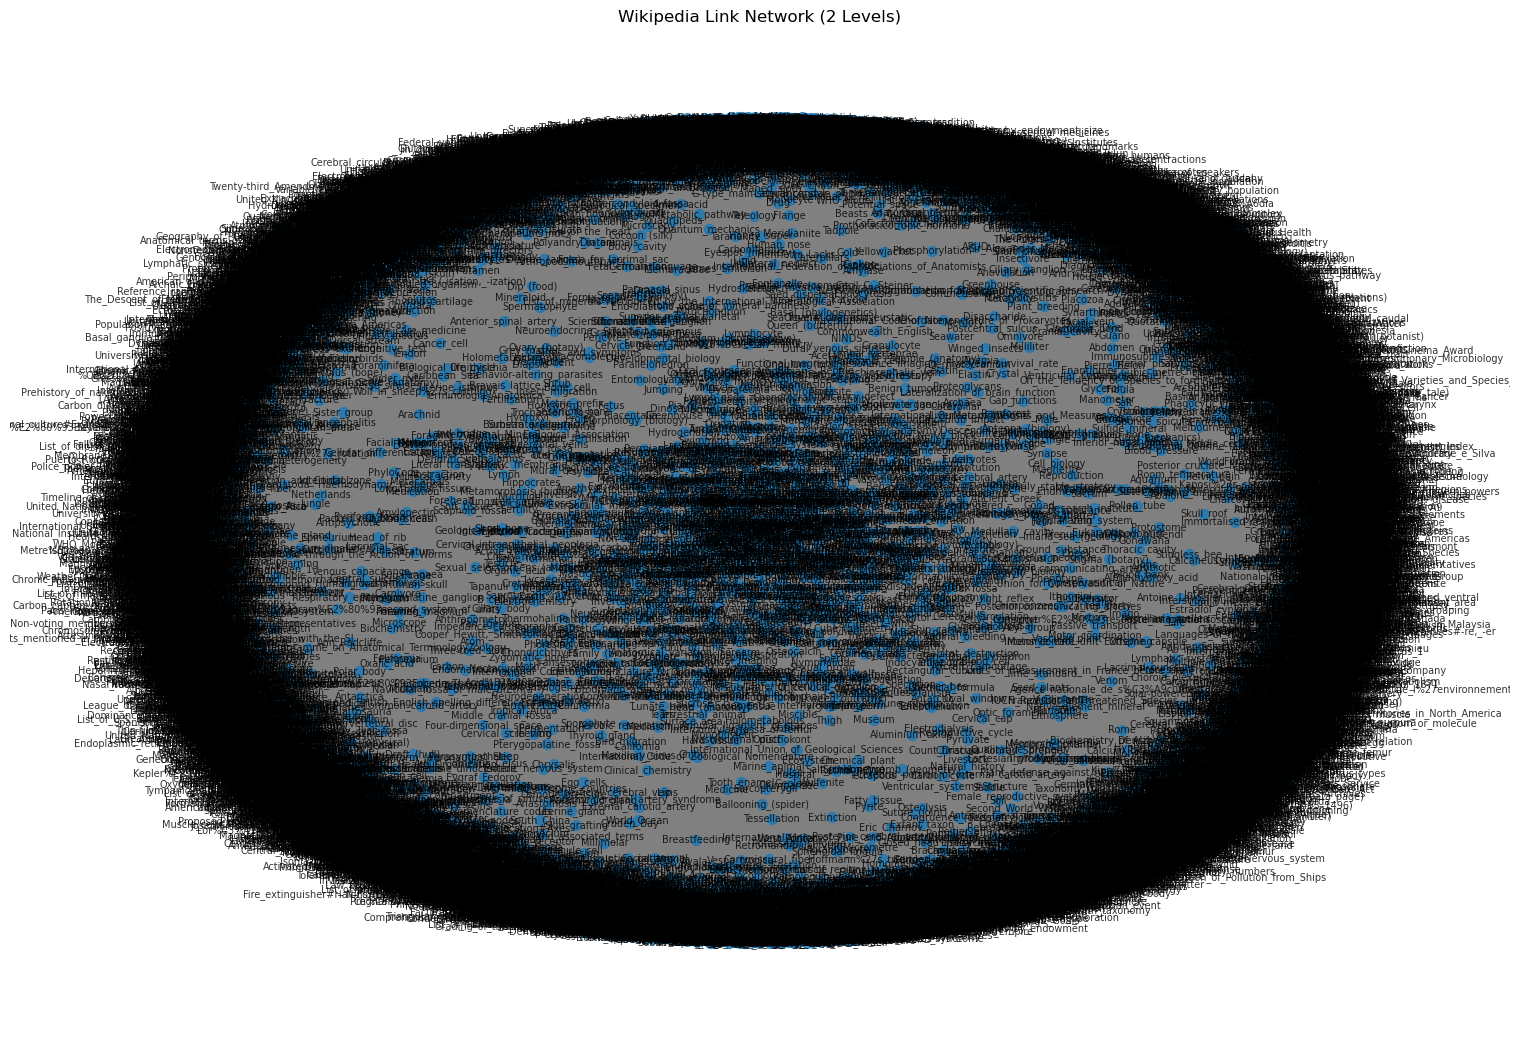

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(graph, k=0.3)  # Layout algorithm
nx.draw(
    graph, pos,
    with_labels=True,
    node_size=50,
    font_size=7,
    alpha=0.8,
    edge_color='gray'
)
plt.title("Wikipedia Link Network (2 Levels)")
plt.show()

In [7]:
degree_centrality = nx.degree_centrality(graph)
top_pages = sorted(degree_centrality.items(), key=lambda x: -x[1])[:5]

print("Most connected pages:")
for page, score in top_pages:
    print(f"{page} (Score: {score:.2f})")

Most connected pages:
Water (Score: 0.04)
List_of_minerals_named_after_people (Score: 0.04)
World_Health_Organization%27s_List_of_Essential_Medicines (Score: 0.04)
Hydrogen (Score: 0.02)
Carbon_dioxide (Score: 0.02)
